In \[1\]:

    import pandas as pd
    import numpy as np
    from datetime import datetime
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler, normalize
    from tqdm import tqdm
    from sklearn.neighbors import KNeighborsClassifier
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
    from imblearn.over_sampling import SMOTE
    import warnings

In \[2\]:

    rf_df = pd.read_excel('../redflag_report/redflag_report_220803.xlsx')
    all_df = pd.read_excel('ml_model_data_6mon_220818.xlsx', sheet_name = 'Report', header = 9)

Data Preprocessing<a href="#Data-Preprocessing" class="anchor-link">¶</a>
=========================================================================

In \[3\]:

    #labelling claims based on red flag report
    all_df['class'] = np.where(all_df['Mat_#_M+H_installed'].isin(rf_df['Mat_#_M+H_installed'].tolist()), 1, 0)

    all_df.drop(['Unnamed: 0'], inplace = True, axis = 1)
    all_df.drop(['Unnamed: 2'], inplace = True, axis = 1)
    all_df.drop(['Unnamed: 13'], inplace = True, axis = 1)
    all_df.rename(columns = {'Unnamed: 21' : 'Number of claims'}, inplace = True)
    all_df.rename(columns = {'EUR' : 'amount_claimed'}, inplace = True)
    all_df = all_df[all_df['Mat_#_M+H_installed'] != 'PWYEMA1000'] #dummy part number

    #replace missing data with 0
    all_df['Months_in_Service'] = all_df['Months_in_Service'].replace(['#'], 0)
    all_df['Veh_mileage_(km)'] = all_df['Veh_mileage_(km)'].replace(['#'], 0)
    all_df['Veh_Oper_Hours'] = all_df['Veh_Oper_Hours'].replace(['#'], 0)
    all_df['Veh_Repair_1_Country'] = all_df['Veh_Repair_1_Country'].replace(['Not assigned'], '0')

    #adding features gap between creation date and repair date & gap between repair date and production date
    all_df['Date_Veh_Prod_Y/M'] = np.where(all_df['Date_Veh_Prod_Y/M'] == 'Not assigned',
                                           all_df['Date_Claim_Crea_Y/M'], all_df['Date_Veh_Prod_Y/M'])
    all_df['Date_Veh_Repair_Y/M'] = np.where(all_df['Date_Veh_Repair_Y/M'] == 'Not assigned',
                                             all_df['Date_Claim_Crea_Y/M'], all_df['Date_Veh_Repair_Y/M'])
    all_df['Date_Veh_Prod_Y/M'] = pd.to_datetime(all_df['Date_Veh_Prod_Y/M'], format = '%b %Y')
    all_df['Date_Claim_Crea_Y/M'] = pd.to_datetime(all_df['Date_Claim_Crea_Y/M'], format = '%b %Y')
    all_df['Date_Veh_Repair_Y/M'] = pd.to_datetime(all_df['Date_Veh_Repair_Y/M'], format = '%b %Y')
    all_df['gap_crea_repair'] = (all_df['Date_Claim_Crea_Y/M'] - all_df['Date_Veh_Repair_Y/M']).dt.days
    all_df['gap_repair_prod'] = (all_df['Date_Veh_Repair_Y/M'] - all_df['Date_Veh_Prod_Y/M']).dt.days

    #transform countries into numbers
    k = sorted(set(all_df['Veh_Repair_1_Country']))
    v = range(len(k))
    d = dict(zip(k,v))
    all_df['Country_code'] = all_df['Veh_Repair_1_Country'].map(d)

In \[4\]:

    #selecting 8 numerical features
    X = all_df.copy()
    X = X[['Veh_mileage_(km)', 'Veh_Oper_Hours', 'Months_in_Service', 'Number of claims', 'amount_claimed', 'gap_crea_repair',
           'gap_repair_prod', 'Country_code', 'class']]
    X

Out\[4\]:

|        | Veh\_mileage\_(km) | Veh\_Oper\_Hours | Months\_in\_Service | Number of claims | amount\_claimed | gap\_crea\_repair | gap\_repair\_prod | Country\_code | class |
|--------|--------------------|------------------|---------------------|------------------|-----------------|-------------------|-------------------|---------------|-------|
| 0      | 36049              | 0                | 41                  | 1                | 789.66          | 31                | 1308              | 122           | 0     |
| 1      | 52746              | 0                | 35                  | 1                | 39.16           | 28                | 1096              | 122           | 0     |
| 2      | 23823              | 0                | 28                  | 1                | 52.08           | 212               | 1065              | 122           | 0     |
| 3      | 38570              | 0                | 50                  | 1                | 362.02          | 92                | 1491              | 122           | 0     |
| 4      | 13362              | 0                | 28                  | 1                | 521.86          | 153               | 884               | 122           | 0     |
| ...    | ...                | ...              | ...                 | ...              | ...             | ...               | ...               | ...           | ...   |
| 135587 | 0                  | 0                | 0                   | 1                | 0.00            | 0                 | 0                 | 0             | 0     |
| 135588 | 0                  | 0                | 0                   | 1                | 0.00            | 0                 | 0                 | 0             | 0     |
| 135589 | 0                  | 0                | 0                   | 1                | 0.00            | 0                 | 0                 | 0             | 0     |
| 135590 | 0                  | 0                | 0                   | 1                | 0.00            | 0                 | 0                 | 0             | 0     |
| 135591 | 0                  | 0                | 0                   | 1                | 0.00            | 0                 | 0                 | 0             | 0     |

134077 rows × 9 columns

In \[5\]:

    #split training dataset and testing dataset
    train, test = train_test_split(X, test_size = 0.20, random_state = 5)

    X_test = test.drop(['class'], axis = 1)
    y_test = test['class']
    X_test = normalize(X_test)

In \[6\]:

    #train dataset - imbalanced
    n_classes = train['class'].value_counts()
    total = train['class'].count()
    print(f'There are {total} values, from which {n_classes[0]} are normal and {n_classes[1]} are suspicious.\n')
    print(f'normal: {round(n_classes[0] * 100 / total, 1)} %\nsuspicious:    {round(n_classes[1] * 100 / total, 1)} %')

    There are 107261 values, from which 34010 are normal and 73251 are suspicious.

    normal: 31.7 %
    suspicious:    68.3 %

In \[7\]:

    '''
    Down sampling
    ----------------------------------------------
    normal = train.loc[train['class']==0]
    suspicious = train.loc[train['class']==1].sample(n=normal.shape[0], random_state=5)

    train = pd.concat([normal, suspicious])
    train = train.sample(frac=1, random_state=0)
    train.reset_index(drop=True, inplace=True)

    X_train = train.drop(['class'], axis = 1)
    y_train = train['class']
    X_train = normalize(X_train)
    '''
    '''
    SMOTE - Over sampling
    ----------------------------------------------
    '''
    warnings.filterwarnings("ignore")

    X_train = train.drop(['class'], axis = 1)
    y_train = train['class']

    sm = SMOTE(random_state = 5)
    X_res, y_res = sm.fit_resample(X_train, y_train)

    X_train = pd.DataFrame(X_res, columns = X_train.columns)
    y_train = y_res
    X_train = normalize(X_train)

In \[8\]:

    y_res.value_counts()

Out\[8\]:

    1    73251
    0    73251
    Name: class, dtype: int64

Logistic Regression<a href="#Logistic-Regression" class="anchor-link">¶</a>
===========================================================================

In \[12\]:

    from sklearn.linear_model import LogisticRegression

    logisreg = LogisticRegression()
    logisreg.fit(X_train, y_train)

    y_pred = logisreg.predict(X_test)

    print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

               0       0.78      0.22      0.34      8429
               1       0.73      0.97      0.83     18387

        accuracy                           0.74     26816
       macro avg       0.75      0.60      0.59     26816
    weighted avg       0.75      0.74      0.68     26816

SVM<a href="#SVM" class="anchor-link">¶</a>
===========================================

In \[19\]:

    from sklearn import svm
    # about 50 mins to train
    model = svm.SVC()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

               0       0.82      0.21      0.34      8429
               1       0.73      0.98      0.84     18387

        accuracy                           0.74     26816
       macro avg       0.77      0.60      0.59     26816
    weighted avg       0.76      0.74      0.68     26816

Linear Discriminent Analysis<a href="#Linear-Discriminent-Analysis" class="anchor-link">¶</a>
=============================================================================================

In \[20\]:

    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

    model = LinearDiscriminantAnalysis()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

               0       0.85      0.19      0.31      8429
               1       0.73      0.98      0.84     18387

        accuracy                           0.73     26816
       macro avg       0.79      0.59      0.57     26816
    weighted avg       0.76      0.73      0.67     26816

Gaussian Naive Bayes<a href="#Gaussian-Naive-Bayes" class="anchor-link">¶</a>
=============================================================================

In \[33\]:

    from sklearn.naive_bayes import GaussianNB

    model = GaussianNB()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

               0       0.82      0.18      0.30      8429
               1       0.72      0.98      0.83     18387

        accuracy                           0.73     26816
       macro avg       0.77      0.58      0.57     26816
    weighted avg       0.76      0.73      0.67     26816

KNN<a href="#KNN" class="anchor-link">¶</a>
===========================================

In \[13\]:

    neighbours = np.arange(1,25)
    train_accuracy =np.empty(len(neighbours))
    test_accuracy = np.empty(len(neighbours))

    for i,k in tqdm(enumerate(neighbours)):
        #Setup a knn classifier with k neighbors
        knn=KNeighborsClassifier(n_neighbors = k, n_jobs = -1)
        
        #Fit the model
        knn.fit(X_train,y_train.ravel())
        
        #Compute accuracy on the training set
        train_accuracy[i] = knn.score(X_train, y_train.ravel())
        
        #Compute accuracy on the test set
        test_accuracy[i] = knn.score(X_test, y_test.ravel()) 
        
    plt.title('k-NN Varying number of neighbors')
    plt.plot(neighbours, test_accuracy, label='Testing Accuracy')
    plt.plot(neighbours, train_accuracy, label='Training accuracy')
    plt.legend()
    plt.xlabel('Number of neighbors')
    plt.ylabel('Accuracy')
    plt.show()

    24it [06:03, 15.13s/it]

<img src="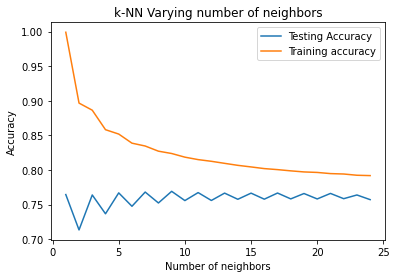%0A" class="jp-needs-light-background" />

In \[15\]:

    idx = np.where(test_accuracy == max(test_accuracy))
    k = neighbours[idx]

    knn=KNeighborsClassifier(n_neighbors=k[0], n_jobs=-1)
    knn.fit(X_train,y_train.ravel())

    knn_predicted_test_labels=knn.predict(X_test)
    print(classification_report(y_test,knn_predicted_test_labels))

                  precision    recall  f1-score   support

               0       0.61      0.74      0.67      8429
               1       0.87      0.78      0.82     18387

        accuracy                           0.77     26816
       macro avg       0.74      0.76      0.75     26816
    weighted avg       0.79      0.77      0.77     26816

Decision Tree<a href="#Decision-Tree" class="anchor-link">¶</a>
===============================================================

In \[11\]:

    from sklearn.tree import DecisionTreeClassifier

    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(classification_report(y_test,y_pred))

                  precision    recall  f1-score   support

               0       0.67      0.75      0.71      8429
               1       0.88      0.83      0.85     18387

        accuracy                           0.80     26816
       macro avg       0.77      0.79      0.78     26816
    weighted avg       0.81      0.80      0.81     26816

Random Forest<a href="#Random-Forest" class="anchor-link">¶</a>
===============================================================

In \[37\]:

    from sklearn.ensemble import RandomForestClassifier

    model = RandomForestClassifier(random_state = 5)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(classification_report(y_test,y_pred))

                  precision    recall  f1-score   support

               0       0.71      0.82      0.76      8429
               1       0.91      0.85      0.88     18387

        accuracy                           0.84     26816
       macro avg       0.81      0.84      0.82     26816
    weighted avg       0.85      0.84      0.84     26816

In \[9\]:

    from sklearn.model_selection import RandomizedSearchCV

    #tuning parameters for random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]

    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

In \[10\]:

    #takes about 5 hours to run
    rf = RandomForestClassifier(random_state = 5)
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3,
                                   verbose = 2, random_state = 5, n_jobs = -1)
    rf_random.fit(X_train, y_train)

    Fitting 3 folds for each of 10 candidates, totalling 30 fits

Out\[10\]:

    RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=5),
                       n_jobs=-1,
                       param_distributions={'bootstrap': [True, False],
                                            'max_depth': [10, 20, 30, 40, 50, 60,
                                                          70, 80, 90, 100, 110,
                                                          None],
                                            'max_features': ['auto', 'sqrt'],
                                            'min_samples_leaf': [1, 2, 4],
                                            'min_samples_split': [2, 5, 10],
                                            'n_estimators': [200, 400, 600, 800,
                                                             1000, 1200, 1400, 1600,
                                                             1800, 2000]},
                       random_state=5, verbose=2)

**In a Jupyter environment, please rerun this cell to show the HTML
representation or trust the notebook.  
On GitHub, the HTML representation is unable to render, please try
loading this page with nbviewer.org.**

RandomizedSearchCV

    RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=5),
                       n_jobs=-1,
                       param_distributions={'bootstrap': [True, False],
                                            'max_depth': [10, 20, 30, 40, 50, 60,
                                                          70, 80, 90, 100, 110,
                                                          None],
                                            'max_features': ['auto', 'sqrt'],
                                            'min_samples_leaf': [1, 2, 4],
                                            'min_samples_split': [2, 5, 10],
                                            'n_estimators': [200, 400, 600, 800,
                                                             1000, 1200, 1400, 1600,
                                                             1800, 2000]},
                       random_state=5, verbose=2)

estimator: RandomForestClassifier

    RandomForestClassifier(random_state=5)

RandomForestClassifier

    RandomForestClassifier(random_state=5)

In \[11\]:

    rf_random.best_params_

Out\[11\]:

    {'n_estimators': 1200,
     'min_samples_split': 2,
     'min_samples_leaf': 2,
     'max_features': 'auto',
     'max_depth': 50,
     'bootstrap': False}

In \[12\]:

    #best model through randomized search
    best_random = rf_random.best_estimator_
    y_pred = best_random.predict(X_test)
    print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

               0       0.72      0.82      0.77      8512
               1       0.91      0.85      0.88     18304

        accuracy                           0.84     26816
       macro avg       0.82      0.84      0.82     26816
    weighted avg       0.85      0.84      0.84     26816

In \[12\]:

    #plot feature importance
    importance = best_random.feature_importances_
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

<img src="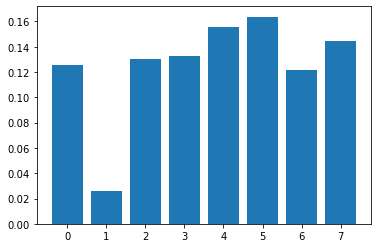%0A" class="jp-needs-light-background" />